### Analyzie coeffficient of partial determination for entire population, and split by regions

In [23]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
ALPHA = 0.05
sessions = pd.read_pickle(SESSIONS_PATH)

In [43]:
# REGION = "Hippocampus/MTL"
# REGION = "hippocampal_formation (HF)"
# REGION = "orbital_frontal_cortex (OFC)"
REGION = "all"
units = spike_utils.get_unit_positions(sessions)
region_units = units
# region_units = units[units.manual_structure == REGION]
# region_units = units[units.structure_level3 == REGION]
# region_units = units[units.structure_level2 == REGION]

In [35]:
def get_res_per_session(row):
    session = row.session_name
    separate_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_fr_50_feature_rpe_separate.pickle"))
    separate_res["TimeIdxs"] = (separate_res["TimeBins"] * 20).astype(int)
    separate_res = separate_res.rename(columns={"score": "separate_score"})

    interaction_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_fr_50_feature_rpe_interaction.pickle"))
    interaction_res["TimeIdxs"] = (interaction_res["TimeBins"] * 20).astype(int)
    interaction_res = interaction_res.rename(columns={"score": "interaction_score"})

    # shuffled_res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_feature_rpe_shuffles.pickle"))        
    # shuffled_res["TimeIdxs"] = (shuffled_res["TimeBins"] * 20).astype(int)

    # sig_stats = glm_utils.calculate_sig_stats(shuffled_res, ALPHA, 1)
    # sig_stats["TimeIdxs"] = (sig_stats["TimeBins"] * 20).astype(int)

    merged = pd.merge(separate_res, interaction_res, on=["UnitID", "TimeIdxs"])
    # merged = pd.merge(merged, sig_stats, on=["UnitID", "TimeIdxs"])

    pos = spike_utils.get_unit_positions_per_sess(session)
    pos = pos.fillna("unknown")
    pos = spike_utils.get_manual_structure(pos)

    with_pos = pd.merge(merged, pos, on=["UnitID"])
    with_pos["PseudoUnitID"] = int(session) * 100 + with_pos["UnitID"]
    return with_pos[["PseudoUnitID", "TimeIdxs", "separate_score", "interaction_score", "manual_structure"]]
    # return with_pos[["PseudoUnitID", "TimeBins", "TimeIdxs", "separate_score", "interaction_score", "sig_bound", "manual_structure"]]

In [36]:
unit_res = pd.concat(sessions.apply(get_res_per_session, axis=1).values).reset_index(drop=True)
# unit_res = unit_res[unit_res.PseudoUnitID.isin(region_units.PseudoUnitID)]

In [39]:
unit_res["additional_score"] = 1 - (1 - unit_res["interaction_score"]) / (1 - unit_res["separate_score"])
# unit_res["sig_additional_score"] = 1 - (1 - unit_res["sig_bound"]) / (1 - unit_res["separate_score"])

In [37]:
unit_res

,PseudoUnitID,TimeIdxs,separate_score,interaction_score,manual_structure
0,2018070900,0,0.010296,0.018717,Claustrum
1,2018070900,1,0.009803,0.016765,Claustrum
2,2018070900,2,0.005821,0.012414,Claustrum
3,2018070900,3,0.005199,0.012574,Claustrum
4,2018070900,4,0.005439,0.013043,Claustrum
...,...,...,...,...,...
42331,2018091029,51,0.018565,0.032093,Amygdala
42332,2018091029,52,0.013957,0.025488,Amygdala
42333,2018091029,53,0.013318,0.023694,Amygdala
42334,2018091029,54,0.013431,0.023462,Amygdala


/tmp/ipykernel_3684483/3763582492.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeIdxs").mean().reset_index()
/tmp/ipykernel_3684483/3763582492.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeIdxs").mean().reset_index()
/tmp/ipykernel_3684483/3763582492.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avged = region_res.groupby("TimeIdxs").mean

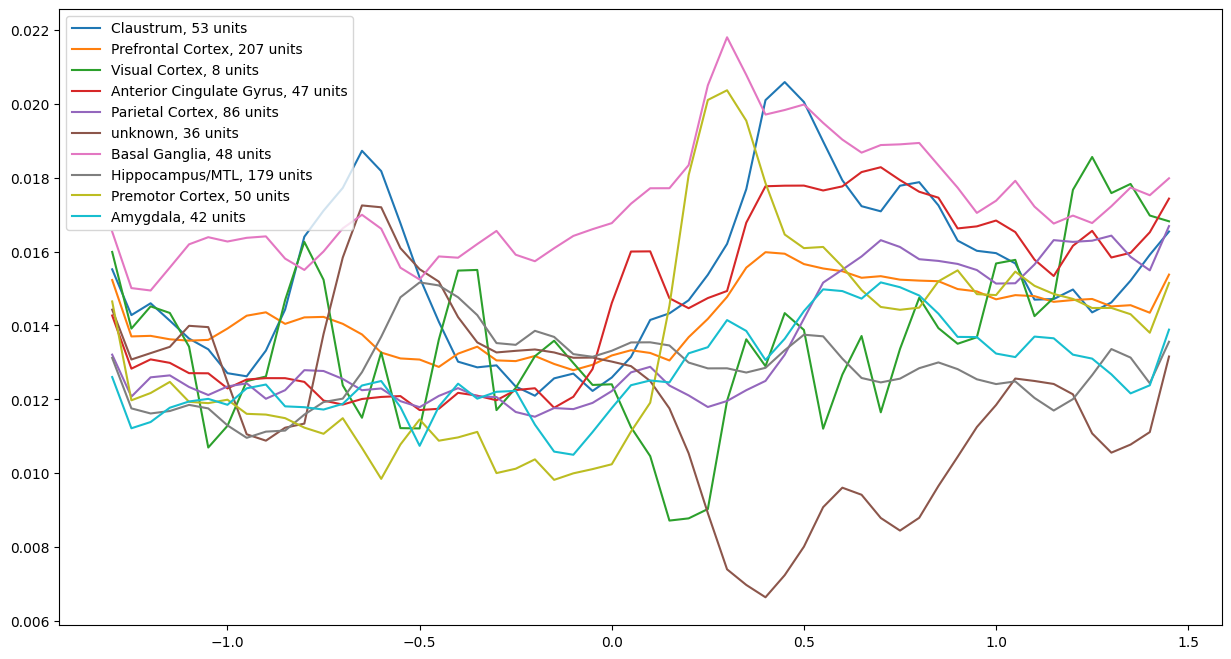

In [42]:
fig, ax = plt.subplots(figsize=(15, 8))
time = np.arange(-1.3, 1.5, 0.05)

for region in unit_res.manual_structure.unique():
    region_res = unit_res[unit_res.manual_structure == region]
    avged = region_res.groupby("TimeIdxs").mean().reset_index()
    ax.plot(time, avged.additional_score, label=f"{region}, {len(region_res.PseudoUnitID.unique())} units")
ax.legend()


In [63]:
avged = unit_res.groupby("TimeBins")["additional_score", "sig_additional_score"].mean().reset_index()

/tmp/ipykernel_3629507/3452084166.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avged = unit_res.groupby("TimeBins")["additional_score", "sig_additional_score"].mean().reset_index()


Text(0.5, 1.0, 'all, 756 units')

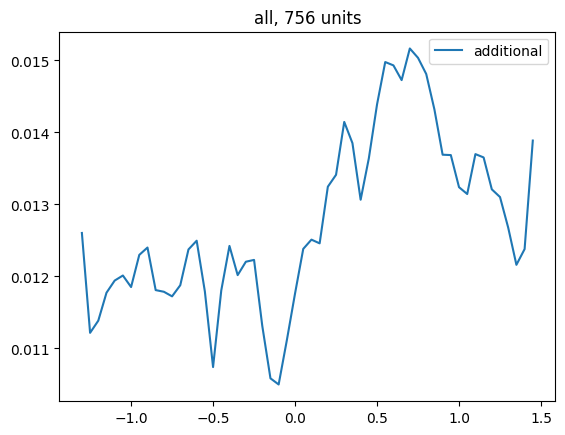

In [45]:
fig, ax = plt.subplots()
time = np.arange(-1.3, 1.5, 0.05)
ax.plot(time, avged.additional_score, label="additional")
# ax.plot(time, avged.sig_additional_score, label="sig bound")
ax.legend()
ax.set_title(f"{REGION}, {len(unit_res.PseudoUnitID.unique())} units")